In [1]:
1

1

In [2]:
2

2

In [4]:
import numpy as np
import tensorflow.keras
from tensorflow import keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle
import matplotlib.pyplot as plt
import math



In [10]:
output_dir = "../output/tests2"
os.listdir(output_dir)

['scattering_J-10_Q-01_order1_score.pkl',
 'J-14_Q-01_order2.h5',
 'scattering_J-10_Q-01_order2_score.pkl',
 'J-14_Q-01_order1.h5',
 'scattering_J-06_Q-01_order1_score.pkl',
 'J-08_Q-01_order2.h5',
 'J-06_Q-01_order1.h5',
 'J-08_Q-01_order1.h5',
 'scattering_J-14_Q-01_order1_score.pkl',
 'scattering_J-12_Q-01_order1_score.pkl',
 'scattering_J-12_Q-01_order2_score.pkl',
 'J-10_Q-01_order1.h5',
 'scattering_J-14_Q-01_order2_score.pkl',
 'scattering_J-08_Q-01_order1_score.pkl',
 'J-10_Q-01_order2.h5',
 'scattering_J-08_Q-01_order2_score.pkl',
 'J-12_Q-01_order1.h5',
 'J-12_Q-01_order2.h5']

In [6]:
J=[6,8,10,12,14]
order = [1,2]
Q=1

In [11]:
def create_model_adjustable(J,Q,order,k_size,nchan_out,activation):
	N = 2**15
	y = np.random.rand(N)
	scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
	Sy = np.array(scattering(torch.Tensor(y))).T
	input_x,input_y = Sy.shape
	nchan_in = 1       # number of input channels.  1 since it is BW

	input_shape = (input_x,input_y)#Sy.shape
	kernel_size = (k_size,)
	K.clear_session()
	model=Sequential()
	#1 conv layer +  1 batch normalization + nonlinear activation + pooling
	model.add(BatchNormalization(input_shape=input_shape))
	model.add(Conv1D(filters=nchan_out,
		kernel_size=kernel_size, padding="same",name='conv1'))
	#model.add(BatchNormalization())
	model.add(Activation("relu"))

	if model.layers[-1].output_shape[1]>=4:
		pool = 4
	elif model.layers[-1].output_shape[1]==2:
		pool = 2
	    
	model.add(AveragePooling1D(pool_size=(pool,)))


	for i in range(3):
		model.add(Conv1D(filters=nchan_out,
		             kernel_size=kernel_size, padding="same" ))
		model.add(BatchNormalization())
		model.add(Activation("relu"))
		#print('before pool',model.layers[-1].output_shape)
		if model.layers[-1].output_shape[1] >= 4:
			model.add(AveragePooling1D(pool_size=(4,)))
		elif model.layers[-1].output_shape[1] == 2:
			model.add(AveragePooling1D(pool_size=(2,)))
		#print(model.layers[-1].output_shape)

	model.add(BatchNormalization())
	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(BatchNormalization())
	#what activation should be chosen for last layer, for regression problem? should be a linear function
	model.add(Dense(5, activation=activation)) #output layer that corresponds to the 5 physical parameters.


	# Compile the model
	model.compile(loss='mse', optimizer='adam', metrics=['mse'])




	return model

In [43]:
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'
record = []
for j in J:
    for o in order:
        if j==6 and o==2:
            pass
        else:
            model_path = os.path.join(
               output_dir, "_".join([ "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]) + ".h5")
            print(model_path)
            model = create_model_adjustable(j,Q,o,k_size=8,nchan_out=16,activation='linear')
            model.load_weights(model_path)
            #load test and train files
            pickle_name = "_".join(
                ["scattering",
                "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]
            )
            pkl_path_test = os.path.join(pkl_dir,pickle_name+"_fold-test.pkl")
            pkl_test = open(pkl_path_test,'rb')
            Sy_test,y_test = pickle.load(pkl_test)
            pkl_path_train = os.path.join(pkl_dir,pickle_name+"_fold-train.pkl")
            pkl_train = open(pkl_path_train, 'rb')
            Sy_train,y_train = pickle.load(pkl_train)

            for idx in range(2,4):
                y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
                y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]

            scaler = MinMaxScaler()
            scaler.fit(y_train)
            y_test_normalized = scaler.transform(y_test)
            #log scale the input
            eps = 1e-11
            Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/eps)
            print("start evaluating")
            hist = model.evaluate(Sy_test_log2,y_test_normalized)
            record.append((j,o,hist[0]))
        

../output/tests/J-06_Q-01_order1.h5


OSError: Unable to open file (unable to open file: name = '../output/tests/J-06_Q-01_order1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

manually fit J-6, order=2


In [17]:
record

[(6, 1, 0.05194204691052437),
 (8, 1, 0.052052471125125885),
 (8, 2, 0.045803333097696304),
 (10, 1, 0.06753752752542495),
 (10, 2, 0.03771992841362953),
 (12, 1, 0.0483383327126503),
 (12, 2, 0.036508769923448564),
 (14, 1, 0.0500540704369545),
 (14, 2, 0.03513952844142914)]

In [18]:
order1 = []
j1 = []
order2 = []
j2= []
for j,o,score in record:
    if o==1:
        order1.append(score)
        j1.append(j)
    elif o==2:
        order2.append(score)
        j2.append(j)
    

(0.0, 0.1)

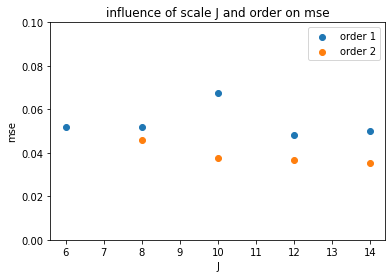

In [38]:
plt.scatter(j1,order1)
plt.scatter(j2,order2)
plt.legend(['order 1', 'order 2'])
plt.xlabel('J')
plt.ylabel('mse')
plt.title('influence of scale J and order on mse')
plt.ylim([0,0.1])

make j-6 order-2 manually

In [13]:
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'
J = 6
Q = 1
order = 2
pickle_name = "_".join(
    ["scattering",
    "J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(order)]
)



In [20]:
pkl_path_train

'/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-06_Q-01_order2_fold-train.pkl'

In [16]:
pkl_path_train = os.path.join(pkl_dir,pickle_name+"_fold-train.pkl")
pkl_train = open(pkl_path_train, 'rb')
print(pkl_train)
#Sy_train,y_train = pickle.load(pkl_train) 

<_io.BufferedReader name='/scratch/hh2263/drum_data/han2020fa_sc-pkl/scattering_J-06_Q-01_order2_fold-train.pkl'>


In [19]:
import os

scores = {} # scores is an empty dict already

if os.path.getsize(pkl_train) > 0:      
    with open(pkl_train, "rb") as f:
        unpickler = pickle.Unpickler(f)
        # if file is not empty scores will be equal
        # to the value unpickled
        scores = unpickler.load()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-645924ef6bce>", line 5, in <module>
    if os.path.getsize(pkl_train) > 0:
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
TypeError: stat: path should be string, bytes, os.PathLike or integer, not _io.BufferedReader

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent ca

TypeError: stat: path should be string, bytes, os.PathLike or integer, not _io.BufferedReader

In [12]:

pkl_path_train = os.path.join(pkl_dir,pickle_name+"_fold-train.pkl")
pkl_train = open(pkl_path_train, 'rb')
Sy_train,y_train = pickle.load(pkl_train) 

pkl_path_val = os.path.join(pkl_dir,pickle_name+"_fold-val.pkl")
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)

pkl_path_test = os.path.join(pkl_dir,pickle_name+"_fold-test.pkl")
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)

#log scale p and D

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-ccbf044b0461>", line 12, in <module>
    Sy_train,y_train = pickle.load(pkl_train)
EOFError: Ran out of input

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'EOFError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1151, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_c

EOFError: Ran out of input

In [ ]:
for idx in range(2,4):
	y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
	y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]
	y_val[:,idx] = [math.log10(i) for i in y_val[:,idx]]

# normalization of the physical parameters
scaler = MinMaxScaler()
scaler.fit(y_train)
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)
y_test_normalized = scaler.transform(y_test)

In [ ]:
#log scale the input
eps = 1e-11
Sy_train_log2 = np.log1p(((Sy_train>0)*Sy_train)/eps)
Sy_val_log2 = np.log1p(((Sy_val>0)*Sy_val)/eps)
Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/eps)

In [ ]:
trial_dir = "../output/tests2/"
os.makedirs(trial_dir, exist_ok=True)
best_validation_loss = np.inf
zoom_factor = 1
n = Sy_train.shape[0]
shape_time = round(Sy_train.shape[1] * zoom_factor)
steps_per_epoch = 50
bs = 64
m = bs*steps_per_epoch
idx = np.arange(0,n,1)
val_loss=[]
train_loss = []
test_loss = []
model_adjustable = create_model_adjustable(J=J,Q=Q,order=order,k_size=8,nchan_out=16,activation='linear')
save_log = os.path.join(trial_dir,pickle_name+"_score.pkl")

In [ ]:
for epoch in range(30):
	np.random.shuffle(idx)
	Sy_temp = Sy_train_log2[idx[:m],:shape_time,:]
	y_temp = y_train_normalized[idx[:m],:]

	hist = model_adjustable.fit(Sy_temp,
				y_temp,
				epochs=1,
				verbose=2,
				batch_size=bs,
				validation_data = (Sy_val_log2[:,-shape_time:,:],y_val_normalized),
				use_multiprocessing=False)

	validation_loss = hist.history['val_loss'][0]

	test_loss.append(model_adjustable.evaluate(Sy_test_log2,y_test_normalized)[0])
	val_loss.append(validation_loss)
	train_loss.append(hist.history['loss'][0])

	if validation_loss < best_validation_loss:
		best_validation_loss = validation_loss
		#epoch_str = "epoch-" + str(epoch).zfill(3)
		epoch_network_path = os.path.join(
		   trial_dir, "_".join([ "J-" + str(J).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(order)]) + ".h5")
		model_adjustable.save(epoch_network_path)

## once i have everything recorded in log files

In [26]:
pickle_name = "_".join(
                ["scattering",
                "J-" + str(6).zfill(2), "Q-" + str(1).zfill(2), "order" + str(1)]
            )
save_log = os.path.join("../output/tests2",pickle_name+"_score.pkl")
print(save_log)
#pkl_test = open(save_log,'rb')

../output/tests2/scattering_J-06_Q-01_order1_score.pkl


In [28]:
pkl_test = open(save_log,'rb')
val_loss,train_loss,test_loss = pickle.load(pkl_test)

In [31]:
 
pkl_dir = '/scratch/hh2263/drum_data/han2020fa_sc-pkl/'
record = []
J=[6,8,10,12,14]
order = [1,2]
order1=[]
order2=[]
j1=[]
j2=[]
for j in J:
    for o in order:
        if j==6 and o==2:
            pass
        else:
            pickle_name = "_".join(
                ["scattering",
                "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]
            )
            save_log = os.path.join("../output/tests2",pickle_name+"_score.pkl")
            pkl_test = open(save_log,'rb')
            val_loss,train_loss,test_loss = pickle.load(pkl_test)
            if o==1:
                order1.append(test_loss)
                j1.append(j)
            else:
                order2.append(test_loss)
                j2.append(j)
        

(0.0, 0.1)

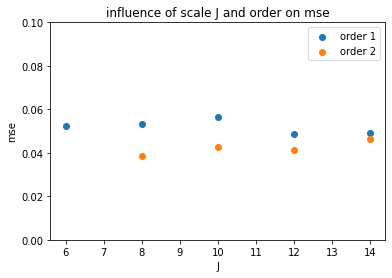

In [32]:
plt.scatter(j1,order1)
plt.scatter(j2,order2)
plt.legend(['order 1', 'order 2'])
plt.xlabel('J')
plt.ylabel('mse')
plt.title('influence of scale J and order on mse')
plt.ylim([0,0.1])

## use j=14 at test1, plot the boxplot

In [78]:

model_path = os.path.join(
               "../output/tests", "_".join([ "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]) + ".h5")
print(model_path)
model_best = create_model_adjustable(14,1,2,k_size=8,nchan_out=16,activation='linear')
model_best.load_weights(model_path)
#load test and train files
pickle_name = "_".join(
    ["scattering",
    "J-" + str(j).zfill(2), "Q-" + str(Q).zfill(2), "order" + str(o)]
)
pkl_path_test = os.path.join(pkl_dir,pickle_name+"_fold-test.pkl")
pkl_test = open(pkl_path_test,'rb')
Sy_test,y_test = pickle.load(pkl_test)
pkl_path_train = os.path.join(pkl_dir,pickle_name+"_fold-train.pkl")
pkl_train = open(pkl_path_train, 'rb')
Sy_train,y_train = pickle.load(pkl_train)

../output/tests/J-14_Q-01_order2.h5


In [79]:
y_train

array([[3641.267682215784, 0.14912260113032105, 0.9748392162093932,
        0.008955332878189611, 0.6462749409737613],
       [1506.983198257637, 0.02073816390265522, 0.023848115806372097,
        0.0004654689467129035, 0.9978264426846492],
       [3070.2718080095915, 0.10129321532386606, 0.0010720601544325409,
        0.02849414339040135, 0.07500050066574436],
       ...,
       [2546.168564047193, 0.08423860474844502, 0.00015907252629495628,
        1.5237960714598444, 0.4578018961631429],
       [11439.22496240364, 0.2208350962998728, 0.03291442582311445,
        0.000227757055623513, 0.5530889499845231],
       [3377.575702619932, 0.1628743803500847, 0.004217992390806481,
        2.806193136121901, 0.6707605813313674]], dtype=object)

In [80]:
for idx in range(2,4):
    y_train[:,idx] = [math.log10(i) for i in y_train[:,idx]]
    y_test[:,idx] = [math.log10(i) for i in y_test[:,idx]]

scaler = MinMaxScaler()
scaler.fit(y_train)
y_test_normalized = scaler.transform(y_test)
#log scale the input
eps = 1e-11
Sy_test_log2 = np.log1p((Sy_test>0)*Sy_test/eps)


In [68]:
Sy_test.shape

(10000, 2, 118)

In [73]:
diff = []
for i in range(10000):
    original = y_test_normalized[i,:]
    Sx = Sy_test_log2[i,:,:]
    recovered = model_best.predict(Sx.reshape((1,2,118)))
    diff.append(recovered-original)
diff_stacked = np.stack(np.abs(diff))

In [74]:
diff_stacked = diff_stacked.reshape((10000,5))

Text(0.5, 1.0, 'Absolute Error between reconstructed and original physical parameters')

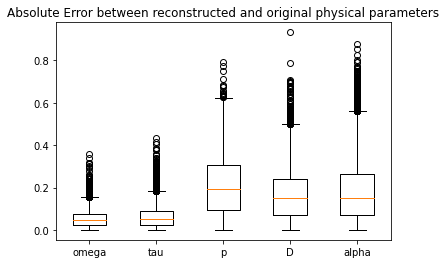

In [77]:
labels = ['omega','tau','p','D','alpha']
plt.boxplot(diff_stacked,labels = labels)
plt.title('Absolute Error between reconstructed and original physical parameters')

interpolate a scattering, reconstruct the sound back, use J/order of the best performing model, predict the shape, measure mse, compare with test loss

In [171]:
import hitdifferentparts
import autograd

In [ ]:
omega = np.linspace(200*np.pi,4000*np.pi,11)
tau = np.linspace(0.01,0.3,11)
p = np.logspace(np.log10(0.0001),np.log10(2),11)
D = np.logspace(np.log10(0.0001),np.log10(10),11)
alpha = np.linspace(0.001,1,11)

In [137]:
np.log10(2)

0.3010299956639812

In [140]:
#want (0.45,0.45)
y_1 = hitdifferentparts.hitdiffparts(0.45,0.5)
y_2 = hitdifferentparts.hitdiffparts(0.45,0.4)
y_3 = hitdifferentparts.hitdiffparts(0.4,0.45)
y_4 = hitdifferentparts.hitdiffparts(0.5,0.45)

--- 1.2667217254638672 seconds ---
--- 1.3070542812347412 seconds ---
--- 1.248049020767212 seconds ---
--- 1.2487316131591797 seconds ---


In [107]:
from tqdm import tnrange, tqdm_notebook
from torch.autograd import backward

In [150]:
#using scattering=3
N=2**15
scattering = Scattering1D(J = 3,shape=(N,), Q = 1, max_order=2)

Sy1 = scattering(torch.Tensor(y_1[:N]))
Sy2 = scattering(torch.Tensor(y_2[:N]))
Sy3 = scattering(torch.Tensor(y_3[:N]))
Sy4 = scattering(torch.Tensor(y_4[:N]))
Sy_interpolated = (Sy1+Sy2+Sy3+Sy4)/4

In [142]:
Sy_interpolated.shape

torch.Size([8, 4096])

In [151]:
y_interpolated,history = regress_signal(
        Sy_interpolated, N=2**15, J=3, learning_rate=100, 
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.6,
        momentum=0.9, 
        NAG = False,
        n_iterations=100, 
        cost = "mse", 
        verbose=True)

/home/hh2263/miniconda3/envs/drum-1.15/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [152]:
y_interpolated = y_interpolated.detach().numpy()

In [163]:
import hitdifferentparts
import IPython.display as ipd
ipd.Audio(y_interpolated,rate=44100)

In [153]:
y_test = [200 * 2 * np.pi,0.2,np.log10(0.3),np.log10(1e-2),1]
y_test = np.array(y_test).reshape((1,5))
print(y_test)

[[ 1.25663706e+03  2.00000000e-01 -5.22878745e-01 -2.00000000e+00
   1.00000000e+00]]


In [154]:
#put into the model j = 14 o = 2
scattering2 = Scattering1D(J = 14,shape=(N,), Q = 1, max_order=2)
Sy_inter_input = scattering2(torch.Tensor(y_interpolated))
y_test_normalized = scaler.transform(np.array(y_test).reshape((1,5)))

In [173]:
#calculate scattering of one sound from the drum
Sy_other = scattering2(torch.Tensor(y_2[:N]))
model_best.evaluate(np.array(Sy_other).reshape(1,2,118),y_test_normalized)

1/1 [==============================] - 0s 2ms/sample - loss: 1.1397 - mean_squared_error: 1.1397


[1.1396843194961548, 1.1396843]

In [172]:
#calculate center scattering
y_center = hitdifferentparts.hitdiffparts(0.5,0.5)
Sy_center = scattering2(torch.Tensor(y_center[:N]))
model_best.evaluate(np.array(Sy_center).reshape(1,2,118),y_test_normalized)

--- 1.2445430755615234 seconds ---
1/1 [==============================] - 0s 2ms/sample - loss: 1.1397 - mean_squared_error: 1.1397


[1.139663577079773, 1.1396636]

In [155]:
print(model_best.layers[0].input_shape,Sy_inter_input.T.shape)

(None, 2, 118) torch.Size([2, 118])


In [175]:
model_best.evaluate(np.array(Sy_inter_input).reshape(1,2,118),y_test_normalized)

1/1 [==============================] - 0s 2ms/sample - loss: 1.1397 - mean_squared_error: 1.1397


[1.1396785974502563, 1.1396786]

In [157]:
recovered = model_best.predict(np.array(Sy_inter_input).reshape(1,2,118))

In [174]:
print(recovered,y_test_normalized)

[[-0.55262405  0.163368    1.0747635  -0.33494672  3.1164331 ]] [[0.05262883 0.65516653 0.80844021 0.39998681 1.00003503]]


In [94]:
def normalize(S):
    S_relu = 1e-6 + torch.nn.functional.relu(S)
    return S_relu / torch.norm(S_relu)

In [92]:
def regress_signal(
        s_c, N, J,
        learning_rate=0.1,
        momentum=0.0,
        NAG = False,
        bold_driver_accelerator=1.1,
        bold_driver_brake=0.5,
        n_iterations=100,
        cost = "mse",
        verbose=False):
    """
    this function finds time-domain signal from scattering transform
    input: scattering tranform tensor, length of the signal(implicitly), learning rate and number of iterations
    output: time-domain signal represented in a tensor
    """
    scattering = Scattering1D(J=J,shape=(N,)) #N is length of signal, J is number of scales
    if cost == "cross-entropy":
        loss = torch.nn.KLDivLoss(reduction='batchmean')
    
    #random guess
    x = torch.randn((N,),requires_grad=True)
    Sx = scattering(x)
    #target
    Sy = s_c
    history = []
    signal_update = 0*x #

    #normalize Sy
    #Sy_normalized,Sy_sum,min_Sy,range_Sy = normalize(Sy) # Sy is the target
    Sy_normalized = normalize(Sy)
    
    #iterate to regress random guess to be close to target
    for it_id in tqdm_notebook(range(n_iterations), disable=not verbose):
        # Backpropagation
        if cost == "mse":
            err = torch.norm(Sx-Sy)
            #backward(torch.norm(Sx - Sy))
        elif cost == "cross-entropy":
            #Sy = Sy.long()
            #np.sum(yHat * np.log((yHat / y)))
            #normalize Sx and Sy - tensor values should always be 0-1 due to nature of cross entropy (correlation between probabilities)
            #Sx_normalized,Sx_sum,min_Sx,range_Sx = normalize(Sx) 
            Sx_normalized = normalize(Sx)
            err = torch.sum(Sx_normalized * torch.log((Sx_normalized / Sy_normalized)))
            #err = loss(torch.log(Sx_normalized), torch.log(Sy_normalized))
            print(err,torch.norm(Sx_normalized,p=2),torch.norm(Sy_normalized,p=2))
            #backward(loss(Sx, Sy))         
        backward(err)
        if NAG == False:
            delta_x = x.grad 
    
        else:
            # for some reasons this nag doesn't have gradient!
            nag_x = torch.tensor(momentum * signal_update + x, requires_grad = True)
            print(nag_x.grad,nag_x)
            delta_x = nag_x.grad
            print(delta_x)
            
        #print(x.grad)

        # Gradient descent
        with torch.no_grad():
            momentum = min(0.99,1-2**(-1-np.log(np.floor(it_id/250)+1)/np.log(2))) #according to paper, adaptive momentum
            signal_update = momentum * signal_update - delta_x * learning_rate
            new_x = x + signal_update
        new_x.requires_grad = True

        # New forward propagation
        Sx = scattering(new_x)
        # Measure the new loss
        history.append(err)
        
        if history[it_id]> history[it_id-1]:
            learning_rate *= bold_driver_brake
        else:
            learning_rate *= bold_driver_accelerator
            x = new_x
        #print(torch.norm(Sx - Sy))
        
        #print("lr = {:6.3f}     loss={:6.3f}".format(learning_rate, history[-1]))
    #Sx_back = revert_normalize(Sx_normalized, Sy_sum,min_Sy,range_Sy)
    return x,history